# Prenatal care and Apgar score

Exploring relationships between prenatal care, apgar score, and gestational age

In [1]:
import warnings

import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm

warnings.filterwarnings('ignore')
norm = colors.Normalize(vmin=28, vmax=40)
viridis = cm.ScalarMappable(norm=norm, cmap='viridis')

In [2]:
def filter_values(row):
    if row.isna().any():
        return True
    if 'Unreliable' in row[['Births', 'Five Minute APGAR Score']]:
        return True
    if 'Not Applicable' in row[['Births', 'Five Minute APGAR Score']]:
        return True
    if float(row['Births']) == 0.0:
        return True
    return False

def get_prenatal(row):
    return row['Month Prenatal Care Began Code'] != 0

prenatal = pd.read_csv('../data/CDC/apgar_score.txt', sep='\t')
prenatal.drop(columns=['Notes', 'Year Code', 'Five Minute APGAR Score Code'], inplace=True)
prenatal['Drop'] = prenatal.apply(filter_values, axis=1)
prenatal = prenatal[prenatal['Drop'] == False].drop(columns='Drop')
prenatal['Prenatal Care'] = prenatal.apply(get_prenatal, axis=1)
prenatal = prenatal.astype({
    'Month Prenatal Care Began Code': int,
    'Year': int,
    'OE Gestational Age Weekly Code': int,
    'Five Minute APGAR Score': int,
    'Births': int
})

subset = prenatal[(prenatal['OE Gestational Age Weekly Code'] >= 28) &
                  (prenatal['OE Gestational Age Weekly Code'] <= 40)]

## Is there a difference between Apgar score with or without prenatal care?

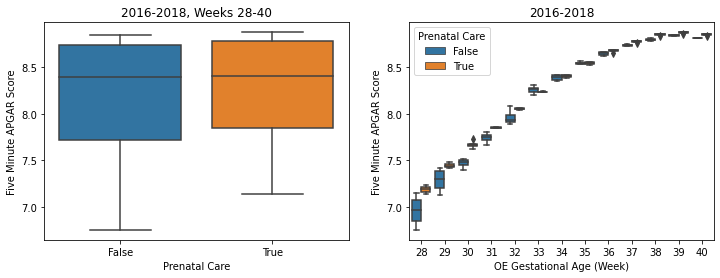

In [3]:
year_list = []
week_list = []
care_list = []
score_list = []
exp_list = []
for year in subset['Year'].unique():
    for week in subset['OE Gestational Age Weekly Code'].unique():
        for care in subset['Prenatal Care'].unique():
            sub = subset[(subset['Year'] == year) &
                         (subset['OE Gestational Age Weekly Code'] == week) &
                         (subset['Prenatal Care'] == care)]
            births = sub['Births']
            scores = sub['Five Minute APGAR Score']
            avg_score = (births*scores).sum()/births.sum()
            year_list.append(year)
            week_list.append(week)
            care_list.append(care)
            score_list.append(avg_score)
            exp_list.append(np.exp(avg_score))
df2 = pd.DataFrame(data={
    'Year': year_list,
    'Gestational Week': week_list,
    'Prenatal Care': care_list,
    'APGAR Score': score_list,
    'Exp APGAR Score': exp_list
})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x='Prenatal Care', y='APGAR Score', data=df2, ax=ax[0])
ax[0].set_ylabel('Five Minute APGAR Score')
ax[0].set_title('2016-2018, Weeks 28-40')

sns.boxplot(x='Gestational Week', y='APGAR Score', hue='Prenatal Care', data=df2, ax=ax[1])
ax[1].set_xlabel('OE Gestational Age (Week)')
ax[1].set_ylabel('Five Minute APGAR Score')
ax[1].set_title('2016-2018')
plt.savefig('../results/apgar_score_1.png', dpi=300)

In [4]:
care = df2[df2['Prenatal Care'] == True]
nocare = df2[df2['Prenatal Care'] == False]
print('00', ttest_ind(care['APGAR Score'], nocare['APGAR Score'], equal_var=False))

for week in df2['Gestational Week'].unique():
    care_sub = care[care['Gestational Week'] == week]
    nocare_sub = nocare[nocare['Gestational Week'] == week]
    print(week, ttest_ind(care_sub['APGAR Score'],
                          nocare_sub['APGAR Score'], equal_var=False))

00 Ttest_indResult(statistic=0.6473501453264799, pvalue=0.5188789491228392)
28 Ttest_indResult(statistic=2.5950568113147447, pvalue=0.0720727929737805)
29 Ttest_indResult(statistic=2.35097179551966, pvalue=0.09340907371903541)
30 Ttest_indResult(statistic=6.046341776763245, pvalue=0.0009856332796803675)
31 Ttest_indResult(statistic=3.6827459050290177, pvalue=0.03268916624770219)
32 Ttest_indResult(statistic=2.2222995044242793, pvalue=0.10875453051883231)
33 Ttest_indResult(statistic=-0.9639794474363225, pvalue=0.4048010982972861)
34 Ttest_indResult(statistic=0.8636877139979388, pvalue=0.4332786046821297)
35 Ttest_indResult(statistic=-0.21305098894102906, pvalue=0.8384367382007162)
36 Ttest_indResult(statistic=2.2228758820652526, pvalue=0.0788006240626661)
37 Ttest_indResult(statistic=5.417828529263757, pvalue=0.0023727870460539245)
38 Ttest_indResult(statistic=6.306426239359521, pvalue=0.0010127397693231036)
39 Ttest_indResult(statistic=5.47159369198268, pvalue=0.0021068429040749883)
4

## Can we fit a model to the data above?

In [5]:
df_f = df2[df2['Prenatal Care'] == False]
model_f = sm.OLS(df_f['Exp APGAR Score'], sm.add_constant(df_f['Gestational Week']))
res_f = model_f.fit()
print(res_f.summary())

                            OLS Regression Results                            
Dep. Variable:        Exp APGAR Score   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1745.
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           1.51e-40
Time:                        21:02:21   Log-Likelihood:                -377.72
No. Observations:                  52   AIC:                             759.4
Df Residuals:                      50   BIC:                             763.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.431e+04    446.630  

In [6]:
df_t = df2[df2['Prenatal Care'] == True]
model_t = sm.OLS(df_t['Exp APGAR Score'], sm.add_constant(df_t['Gestational Week']))
res_t = model_t.fit()
print(res_t.summary())

                            OLS Regression Results                            
Dep. Variable:        Exp APGAR Score   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2441.
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           4.17e-44
Time:                        21:02:21   Log-Likelihood:                -368.76
No. Observations:                  52   AIC:                             741.5
Df Residuals:                      50   BIC:                             745.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.402e+04    375.969  

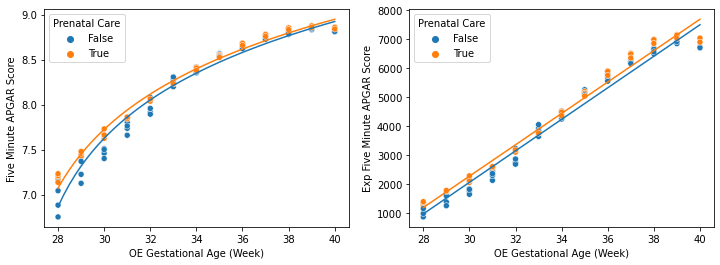

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Gestational Week', y='APGAR Score', hue='Prenatal Care', data=df2, ax=ax[0])
sns.scatterplot(x='Gestational Week', y='Exp APGAR Score', hue='Prenatal Care', data=df2, ax=ax[1])

x = np.linspace(28, 40)
y_f = np.polyval([res_f.params[1], res_f.params[0]], x)
ax[0].plot(x, np.log(y_f))
ax[1].plot(x, y_f)

y_t = np.polyval([res_t.params[1], res_t.params[0]], x)
ax[0].plot(x, np.log(y_t))
ax[1].plot(x, y_t)

ax[0].set_xlabel('OE Gestational Age (Week)')
ax[1].set_xlabel('OE Gestational Age (Week)')
ax[0].set_ylabel('Five Minute APGAR Score')
ax[1].set_ylabel('Exp Five Minute APGAR Score')
plt.savefig('../results/apgar_score_2.png', dpi=300)

## Does the month you start prenatal care matter?

In [8]:
year_list = []
week_list = []
month_list = []
score_list = []
exp_list = []
for year in subset['Year'].unique():
    for week in subset['OE Gestational Age Weekly Code'].unique():
        for month in subset['Month Prenatal Care Began Code'].unique():
            sub = subset[(subset['Year'] == year) &
                         (subset['OE Gestational Age Weekly Code'] == week) &
                         (subset['Month Prenatal Care Began Code'] == month) &
                         (subset['Prenatal Care'] == True)]
            births = sub['Births']
            scores = sub['Five Minute APGAR Score']
            avg_score = (births*scores).sum()/births.sum()
            year_list.append(year)
            week_list.append(week)
            month_list.append(month)
            score_list.append(avg_score)
            exp_list.append(np.exp(avg_score))
df = pd.DataFrame(data={
    'Year': year_list,
    'Gestational Week': week_list,
    'Month Care Began': month_list,
    'APGAR Score': score_list,
    'Exp APGAR Score': exp_list
})
df = df[df['APGAR Score'].isna() == False]
df['Exp APGAR Score'] = df.apply(lambda row: np.exp(row['APGAR Score']), axis=1)
model_me = sm.MixedLM(df['Exp APGAR Score'].values,  # dependent variable
                      df['Month Care Began'].values, # fixed effects covariates
                      df['Gestational Week'].values) # groups
res_me = model_me.fit()
print(res_me.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   y         
No. Observations:   420       Method:               REML      
No. Groups:         13        Scale:                32362.0268
Min. group size:    28        Log-Likelihood:       -2839.8128
Max. group size:    36        Converged:            Yes       
Mean group size:    32.3                                      
--------------------------------------------------------------
             Coef.      Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
x1             -39.420     3.735 -10.554 0.000 -46.741 -32.100
Group Var 25084694.002 55492.173                              



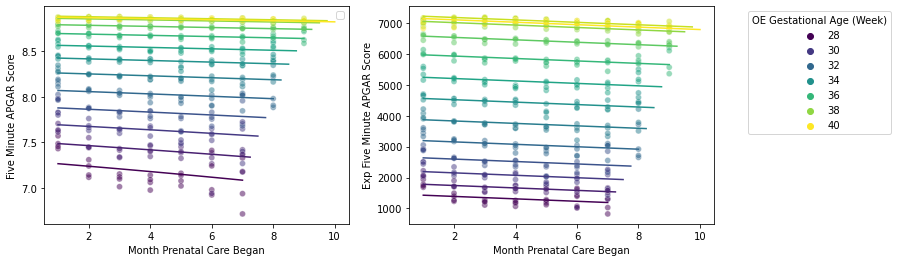

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x='Month Care Began', y='APGAR Score', hue='Gestational Week',
                palette='viridis', data=df, ax=ax[0], alpha=0.5)
sns.scatterplot(x='Month Care Began', y='Exp APGAR Score', hue='Gestational Week',
                palette='viridis', data=df, ax=ax[1], alpha=0.5)

for week in df['Gestational Week'].unique():
    x = np.linspace(1, week/4)
    y = res_me.random_effects[week][0] + res_me.params[0]*x
    ax[0].plot(x, np.log(y), c=viridis.to_rgba(week))
    ax[1].plot(x, y, c=viridis.to_rgba(week))
    
ax[0].set_xlabel('Month Prenatal Care Began')
ax[1].set_xlabel('Month Prenatal Care Began')
ax[0].set_ylabel('Five Minute APGAR Score')
ax[1].set_ylabel('Exp Five Minute APGAR Score')
ax[0].legend('')
ax[1].legend(title='OE Gestational Age (Week)', bbox_to_anchor=(1.6, 1))
plt.savefig('../results/apgar_score_3.png', dpi=300)